# Unsupervised Anomaly Detection on Security Logs using <u>Levenshtein Similarity Score</u>
This is a continuation of the prior research. In this notebook, we are leveraging the Isolation Forest algorithm to perform unsupervised training of an anomaly detection model.  HOWEVER...we are trying this using Levenshtein similarity score INSTEAD OF using text vector embeddings as the input. I expect that this approach will be much less accurate...Levenshtein score is a scalar value that is the minimum number of distinct edits to make two text passages the same, versus a 384-dimension vector embedding output by a language-interpreting LLM that is trying to capture the meaning of the text. This is a no-AI approach to this problem, but it's worth investigating.  Will it work?  Will it come close to the known actual 950/50 split of good/bad log entries?  Let us see...

In [1]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install pandas
#! pip install matplotlib
#! pip install sklearn
#! pip install levenshtein

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import pairwise_distances
#from sklearn.decomposition import PCA
import Levenshtein as lev

In [3]:
# Calculates the minimum number of insertions, deletions, and substitutions required to change one 
# sequence into the other according to Levenshtein with custom costs for insertion, deletion and substitution
# Example:
lev.distance("lewenstein", "levenshtein")

2

In [4]:
# We'll use the fabricated mixed proxy logs with known 950 benign log entries and 50 malicious log entries 
# Our goal is to see if we can get them accurately classified into that 950 benign + 50 malicious
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df.sample(3)

,ID,Log Entry
935,936,"GET http://www.example.com/ HTTP/1.1"" 200 8038..."
463,464,GET http://intranet.company.com/docs/document....
608,609,"GET http://update.software.com/check HTTP/1.1""..."


In [5]:
# Compute the pairwise distance matrix
# This creates a matrix of every row x every row, related back to the original df by the ID/ID
distance_matrix = pairwise_distances(df['Log Entry'].values.reshape(-1, 1), 
                                     metric=lambda x, y: lev.distance(x[0], y[0]))
distance_matrix

array([[  0., 120., 122., ...,  38.,  97., 155.],
       [120.,   0.,  37., ..., 139.,  42.,  98.],
       [122.,  37.,   0., ..., 140.,  42.,  97.],
       ...,
       [ 38., 139., 140., ...,   0., 114., 153.],
       [ 97.,  42.,  42., ..., 114.,   0.,  79.],
       [155.,  98.,  97., ..., 153.,  79.,   0.]])

In [6]:
# Define a model object with the Isolation Forest algorithm
#model=IsolationForest(n_estimators=100,max_samples='auto',contamination=0.05,random_state=96)
#model=IsolationForest(n_estimators=100,max_samples='auto',contamination='auto',random_state=96)
model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Fit the data to the model
model.fit(distance_matrix)

# Display parameter values that were used
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [7]:
# Add a column to the DF for scores from the model's decision_function
df['raw_score'] = model.decision_function(distance_matrix)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score'] = model.predict(distance_matrix)


In [8]:
# Display the data with the columns added
df.sample(3)

,ID,Log Entry,raw_score,anomaly_score
181,182,"GET http://intranet.company.com/home HTTP/1.1""...",0.035521,1
385,386,"GET http://update.software.com/check HTTP/1.1""...",0.064168,1
343,344,"GET http://update.software.com/check HTTP/1.1""...",0.017233,1


In [9]:
# Display just the anomalies
df[df['anomaly_score']==-1].sample(3)

,ID,Log Entry,raw_score,anomaly_score
994,995,GET http://www.example.com/search?q=<script>al...,-0.137784,-1
989,990,GET http://www.example.com/../../etc/passwd HT...,-0.020262,-1
122,123,GET http://update.software.com/version.xml HTT...,-0.002311,-1


In [10]:
# The outliers have anomaly_score = -1
# This is pretty darned good, given that the known actual split is 950/50
df['anomaly_score'].value_counts()

anomaly_score
 1    930
-1     70
Name: count, dtype: int64

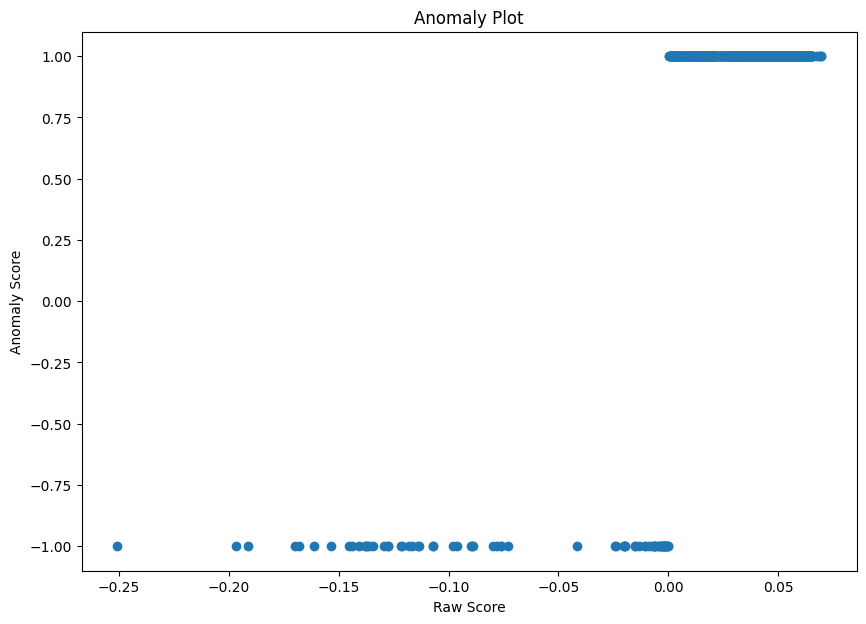

In [11]:
# Scatter plot of the anomaly_score results...it's what we'd expect to see given the counts above
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df.raw_score, df.anomaly_score)
plt.title('Anomaly Plot')
plt.xlabel('Raw Score')
plt.ylabel('Anomaly Score')
plt.show()

Our unsupervised ML model, trained using a very simple distance metric that was merely the number of edits to make two text passages the same, did surprisingly well.  It flagged 70 log entries as anomalies, with 930 seen as typical.  We know the real answer from the fabricated test log entry data is 950 benign and 50 malicious.  We would need to test on real data and/or larger data sets, but this might be at least useable as a coarse-grained pre-filter. 